# K-Centers: A Demo of Variations on K-means Clustering Using Various Cost Metrics
### Author: Daniel Wang

In [1]:
import numpy as np
import sklearn.preprocessing as skpp
import sklearn.datasets as skds
import matplotlib.pyplot as plt

import time
import itertools

from kmeans import KMeans # this is the custom class that we wrote


Using cost metric: L4

Using cost metric: L4

Using cost metric: L4

Using cost metric: L4

Using cost metric: L4

Using cost metric: L4


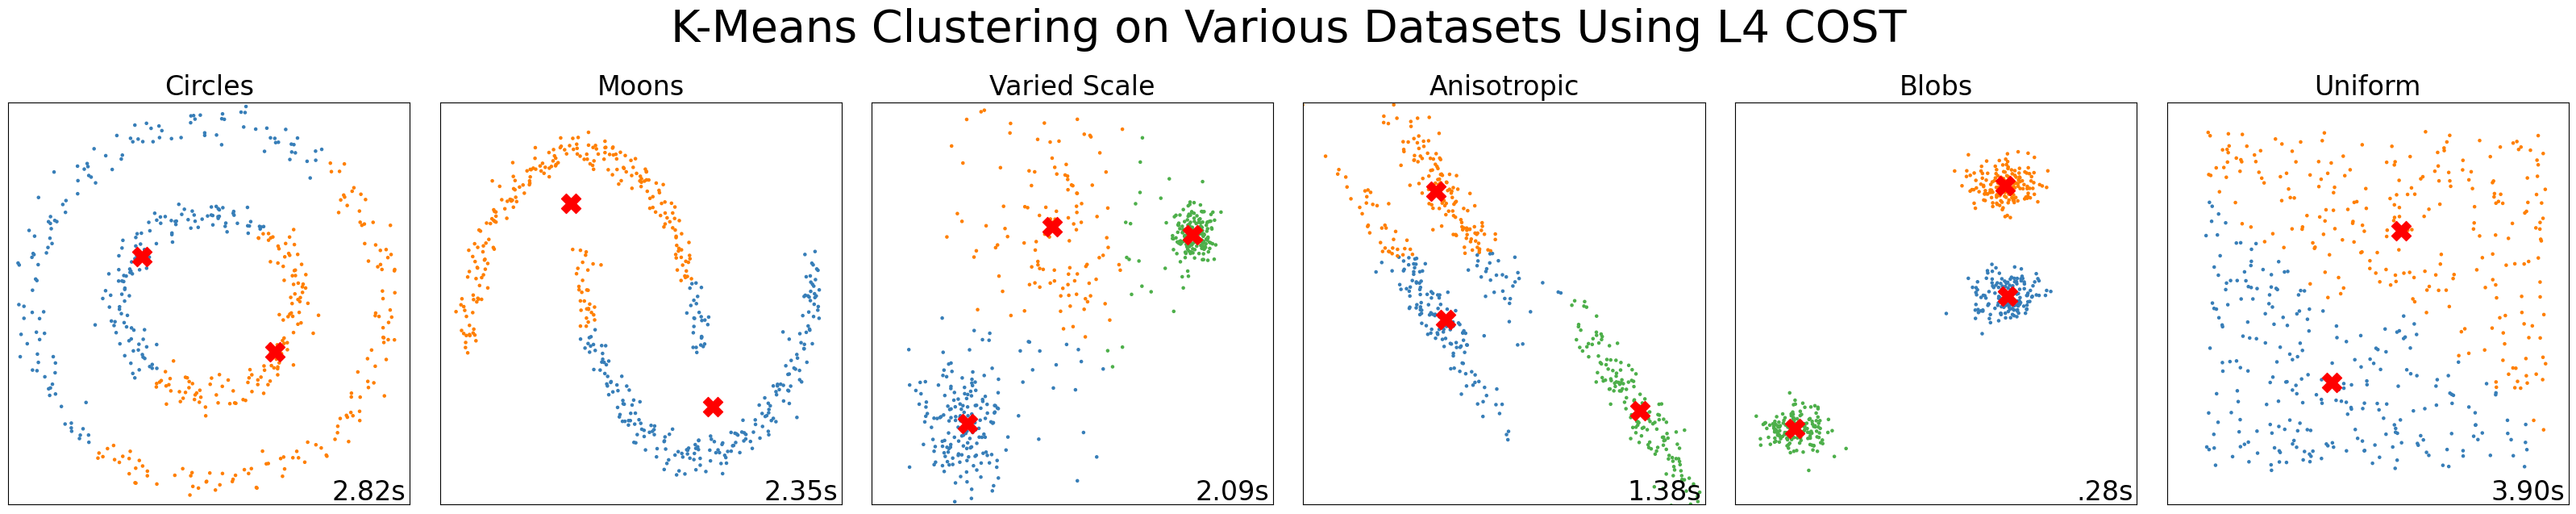

In [2]:
seed = 1

# Generate datasets
n_samples = 500
circles = skds.make_circles(n_samples=n_samples, factor=.5, noise=.05)
moons = skds.make_moons(n_samples=n_samples, noise=.05)
blobs = skds.make_blobs(n_samples=n_samples, random_state=8)
uniform = np.random.rand(n_samples, 2), None

random_state = 170
X, y = skds.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_anisotropic = np.dot(X, transformation)
anisotropic = (X_anisotropic, y)

varied_scale = skds.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

colors = np.array(list(itertools.islice(itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']), len(np.unique(y)))))

cost_metric = 'L4'  # Cost metric

datasets = [circles, moons, varied_scale, anisotropic, blobs, uniform]
dataset_names = ['Circles', 'Moons', 'Varied Scale', 'Anisotropic', 'Blobs', 'Uniform']

# Adjust the figsize parameter based on the number of datasets
fig_width = len(datasets) * 6  # Increase width for larger subplots
fig_height = 6  # Increase height for larger subplots

plt.figure(figsize=(fig_width, fig_height))

plot_num = 1
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = skpp.StandardScaler().fit_transform(X)

    n_clusters = 3 if i_dataset in [2, 3, 4] else 2

    # Create and fit the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300)
    t0 = time.time()
    kmeans.fit(X, cost_metric=cost_metric, descent_rate=0.1, random_state=seed, verbose=False)
    t1 = time.time()
    y_pred = kmeans.predict(X, cost_metric=cost_metric)

    # plot
    plt.subplot(1, len(datasets), plot_num, aspect='equal')
    plt.title(dataset_names[i_dataset], size=24)  # Set title as dataset name
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=5)

    if hasattr(kmeans, 'centroids'):
        centers = kmeans.centroids
        plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', zorder=10, marker='X')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                transform=plt.gca().transAxes, size=24,
                horizontalalignment='right')
    plot_num += 1

# Increase the suptitle font size and adjust the position
plt.suptitle('K-Means Clustering on Various Datasets Using ' + cost_metric.upper() + ' COST', size=40, y=1.05)

plt.tight_layout()
plt.subplots_adjust(wspace=-0.4)  # Adjust the spacing between subplots
plt.show()


## Comparison of K-Medians (using the geometric median) and K-Means (using the centroid)


Using cost metric: squared_euclidean

Using cost metric: euclidean


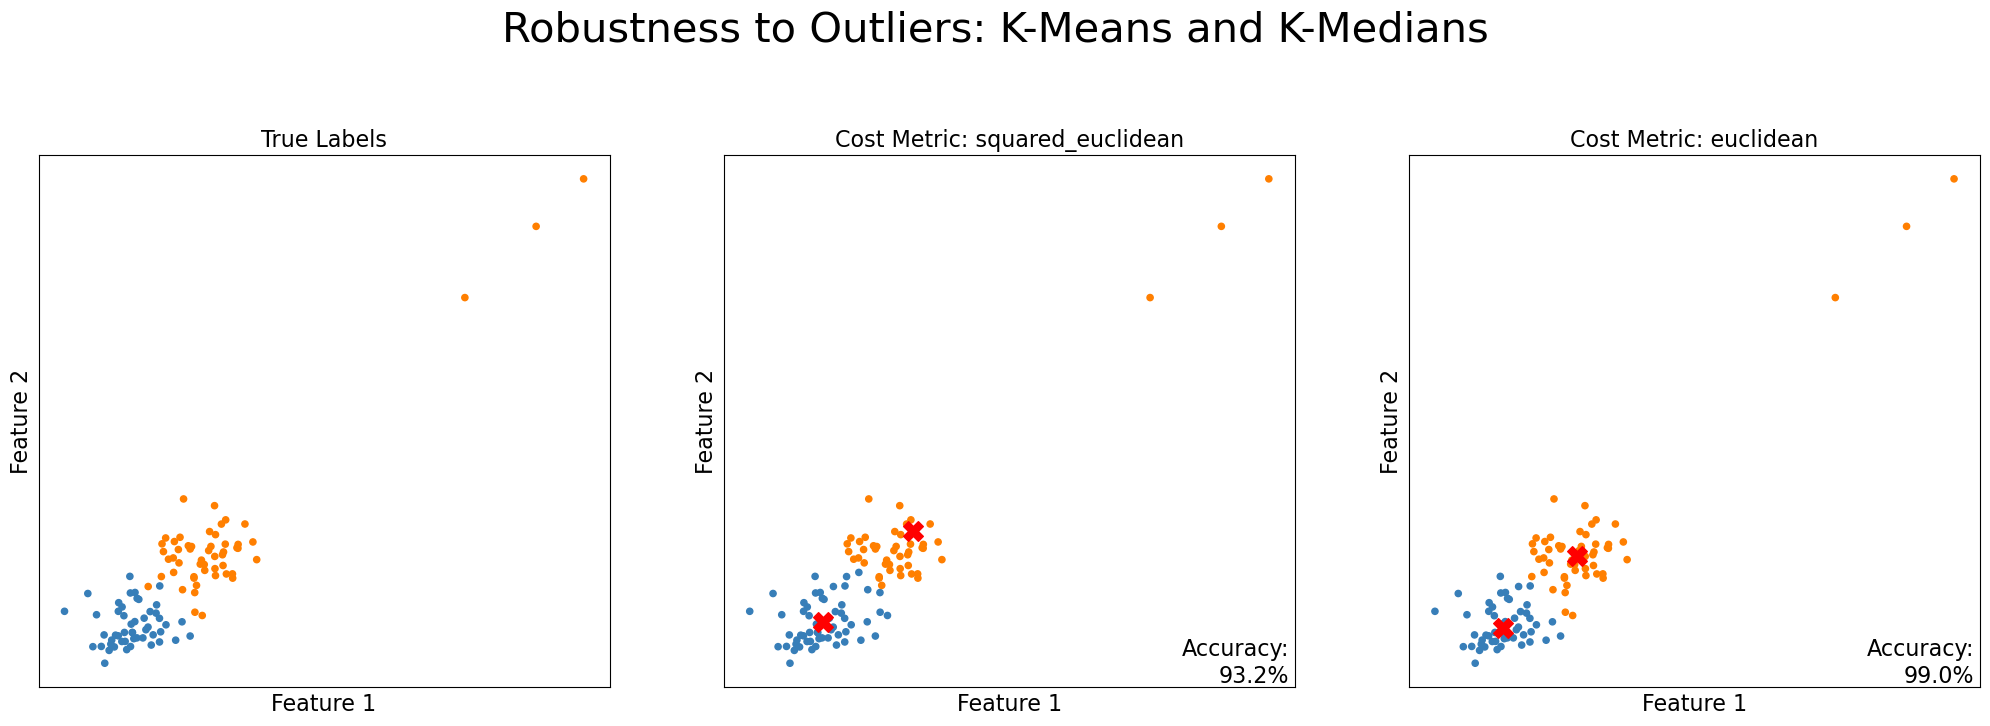

In [3]:
# Generate a synthetic dataset with outliers
seed = 5
n_samples = 100
centers = [[1, 1], [4, 4]]  # Main clusters
outliers = [[15, 15], [18, 18], [20, 20]]  # Outliers far away from the main clusters
X, y = skds.make_blobs(n_samples=n_samples, centers=centers, random_state=seed)
X = np.concatenate([X, outliers])
y = np.concatenate([y, [1, 1, 1]])

# List of cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Create subplots for each cost metric
fig, axes = plt.subplots(1, len(cost_metrics)+1, figsize=(20, 8))
fig.suptitle("Robustness to Outliers: K-Means and K-Medians", fontsize=30)


# Define the color scheme
colors = np.array(list(itertools.islice(itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']), int(max(kmeans.labels) + 1))))
# Plot the original data, colored by the true labels
axes[0].scatter(X[:, 0], X[:, 1], c=colors[y], s=20)
axes[0].set_title('True Labels', size=16)
axes[0].set_xlabel("Feature 1", fontsize=16)
axes[0].set_ylabel("Feature 2", fontsize=16)

# Set common attributes for all subplots
common_attributes = {
    'xticks': [],
    'yticks': [],
    'aspect': 'equal'
}

# Set common attributes using plt.setp()
plt.setp(axes[0], **common_attributes)

# Perform k-means clustering for each cost metric
for i, cost_metric in enumerate(cost_metrics):
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=2, max_iter=600)
    kmeans.fit(X, cost_metric=cost_metric, max_steps=100, random_state=seed, verbose=False)

    # Plot the data points and centroids
    ax = axes[i+1]
    ax.scatter(X[:, 0], X[:, 1], c=colors[kmeans.labels], s=20)
    ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], marker='X', c='red', s=200, zorder=9)
    ax.set_title(f"Cost Metric: {cost_metric}", size=16)
    ax.set_xlabel("Feature 1", fontsize=16)
    ax.set_ylabel("Feature 2", fontsize=16)

    # Set common attributes using plt.setp()
    plt.setp(ax, **common_attributes)

    # Display the accuracy of the labels in the bottom right corner as a percentage
    plt.text(.99, .01, ('Accuracy:\n%.1f%%' % (100*max(np.mean(kmeans.labels == y), np.mean(kmeans.labels != y)))).lstrip('0'),
             transform=ax.transAxes, size=16, horizontalalignment='right')

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust the spacing between subplots
plt.show()



Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cost metric: euclidean

Using cost metric: squared_euclidean

Using cos

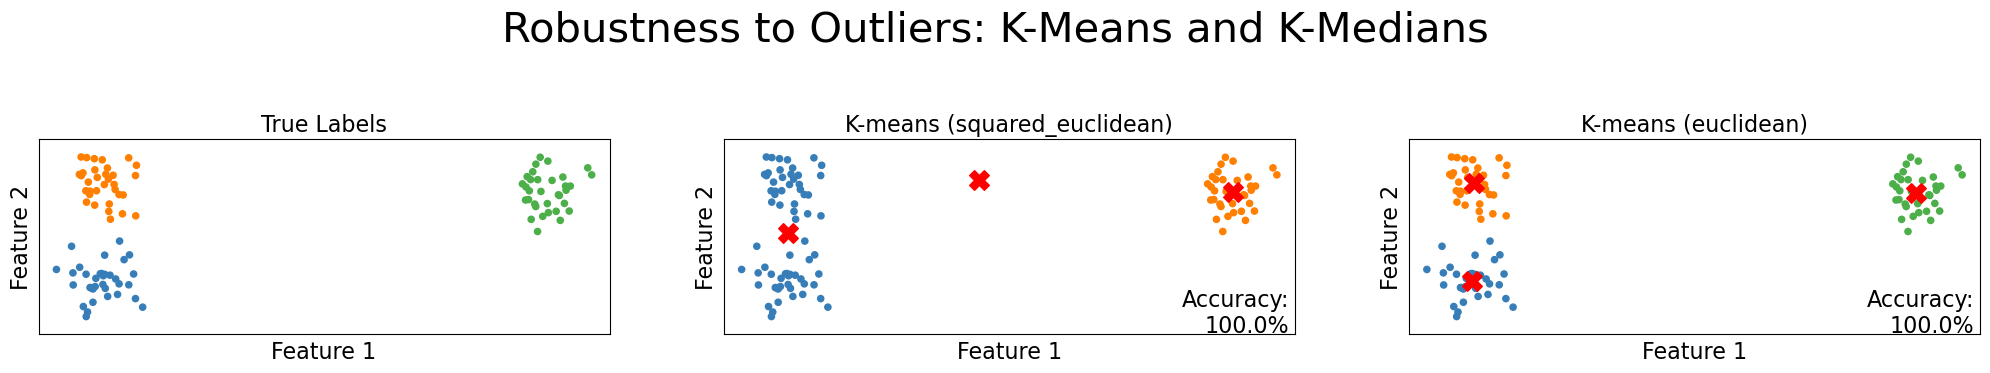

In [19]:
# Generate a synthetic dataset with three blobs
n_samples = 100
centers = [[0, 0], [0, 5], [25, 5]]  # Three main clusters
k = len(centers)
X, y = skds.make_blobs(n_samples=n_samples, centers=centers, random_state=0)

# List of cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']

# Dictionaries to store labels and centroids
label_dict = {}
centroid_dict = {}

accuracies = []  # Store accuracies for each random seed

seed = int(0)
while True:
    seed += 1
    # Perform k-means clustering for each cost metric
    for cost_metric in cost_metrics:
        # Initialize and fit KMeans
        kmeans = KMeans(n_clusters=k, max_iter=400)
        kmeans.fit(X, cost_metric=cost_metric, init='++', max_steps=100, random_state=seed, verbose=False)

        label_dict[cost_metric] = kmeans.labels
        centroid_dict[cost_metric] = kmeans.centroids

        # Calculate accuracy by considering all permutations of the labels
        permuted_labels = list(itertools.permutations(range(k)))
        record_acc = 0.0
        for perm in permuted_labels:
            acc = np.mean(kmeans.labels == np.array([perm[label] for label in y]))
            if acc > record_acc:
                record_acc = acc

        # Append maximum accuracy to the list
        accuracies.append(record_acc)

    # Check if the difference between accuracies is more than 5%
    if len(accuracies) > 1 and abs(accuracies[-1] - accuracies[-2]) > 0.05:
        break

# Create subplots for each cost metric
fig, axes = plt.subplots(1, len(cost_metrics)+1, figsize=(20, 8))
fig.suptitle("Robustness to Outliers: K-Means and K-Medians", fontsize=30, y=0.75)

# Plot the original data, colored by the true labels
unique_labels = range(k)
colors = np.array(list(itertools.islice(itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']), len(unique_labels))))
axes[0].scatter(X[:, 0], X[:, 1], c=colors[y], s=20)
axes[0].set_title('True Labels', size=16)
axes[0].set_xlabel("Feature 1", fontsize=16)
axes[0].set_ylabel("Feature 2", fontsize=16)
axes[0].set_xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
axes[0].set_ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)

# Set common attributes for all subplots
common_attributes = {
    'xticks': [],
    'yticks': [],
    'aspect': 'equal'
}

# Set common attributes using plt.setp()
plt.setp(axes[0], **common_attributes)

# Perform k-means clustering for each cost metric
for i, cost_metric in enumerate(cost_metrics):
    # Define the color scheme
    unique_labels = np.unique(label_dict[cost_metric])
    color_dict = {label: color for label, color in zip(unique_labels, itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']))}

    # Plot the data points and centroids
    ax = axes[i+1]
    ax.scatter(X[:, 0], X[:, 1], c=[color_dict[label] for label in label_dict[cost_metric]], s=20)
    ax.scatter(centroid_dict[cost_metric][:, 0], centroid_dict[cost_metric][:, 1], marker='X', c='red', s=200, zorder=9)
    ax.set_xlabel("Feature 1", fontsize=16)
    ax.set_ylabel("Feature 2", fontsize=16)
    ax.set_xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
    ax.set_ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)

    # Set common attributes using plt.setp()
    plt.setp(ax, **common_attributes)

    # Display the accuracy of the labels in the bottom right corner as a percentage
    plt.text(.99, .01, ('Accuracy:\n%.1f%%' % (100*accuracies[2*i])).lstrip('0'),
                transform=ax.transAxes, size=16, horizontalalignment='right')

    # Set the title based on the cost metric
    ax.set_title(f"K-means ({cost_metric})", size=16)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust the spacing between subplots
plt.show()


In [5]:
# TABAK: Initialize k-means with random assignments for all points (peppered); this is the best since it is the most likely???
# Assigning the centers first is fastest; Assigning the points first is more precise (less likely to get to a local minimum)

# Quality: Measure how much variability is left after transporting
# 

# TABAK: You can do something to predict failure to local minimum; you could just sum the distances after initializing
# Andrew's clarification: SO you're saying that in our philosophy, the way of deciding which clustering (after a loop) is best is to see which minimizes the variability via transport

# Daniel: Desert
# TABAK: Try Fermat distance to cross the desert

# Andrew: Interesting to determine if mean or median is better depending on the type of distribution (e.g. the multiple datasets that Daniel showed last name)
# TABAK: Two questions here: When is the optimal solution better (even if hard to find)? When is it easy to find a reasonably good solution?

# Andrew: Maybe loop your current side-by-side thousands of times